# Data Tigers
## Team 30

This notebook will guide you through the necessary code to perform our Exploratory Data Analysis. For more details please check the report

In [105]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import chi2_contingency

pd.set_option('display.max_columns', None)

In [106]:
DATASET_DIR = Path.cwd().parent/'Datasets'

Lets first load the emergencies dataset extracted from Datos Abiertos and teh precipitation, atmospheric pressure and temeprature datasets preprocessed on BigQuery

In [107]:
#IMPORTING EMERGENCIES CSV FILE
emergencies = pd.read_csv("../Datasets/CONSOLIDADO_EMERGENCIAS 1998-2021 v26052022.csv", 
                          low_memory=False,
                          dtype ={'DIVIPOLA':str})

In [108]:
#CREATING DATE COLUMNS FROM FECHA (THIS IS GOING TO BE USED FOR FILTERING AND MERGING)
#FILTERING BY YEAR >= 2017
emergencies['FECHA'] = pd.to_datetime(emergencies['FECHA'], dayfirst = True)
emergencies.sort_values(by='FECHA')
emergencies['anio_observacion'] = pd.DatetimeIndex(emergencies['FECHA']).year
emergencies['mes_observacion'] = pd.DatetimeIndex(emergencies['FECHA']).month
emergencies['day_observacion'] = pd.DatetimeIndex(emergencies['FECHA']).day
emergencies['doy_observacion'] = pd.DatetimeIndex(emergencies['FECHA']).dayofyear
emergencies = emergencies[emergencies['anio_observacion'] >= 2017]
emergencies = emergencies.drop_duplicates(subset = ['FECHA','EVENTO','DIVIPOLA'])
len(emergencies)

18042

In [109]:
#FILTERING EMERGENCIES BY EVENTO = ['INUNDACION','INUNDACION ','INUNDACIÓN', 'INUNDACIÓN ', 'INUNDACIoN']
events = ['INUNDACION','INUNDACION ','INUNDACIÓN', 'INUNDACIÓN ', 'INUNDACIoN']
floodings = emergencies[emergencies['EVENTO'].isin(events)]
len(floodings)

2708

**Note: Out of 18042 events recorded in the UNGRD Emergencies dataset since Jan-2017, 2708 are flooding events representing around 15% of total recorded emergencies.**

In [110]:
#IMPORTING PRECIPITATION CSV FILE AND FILTERING BY YEAR >= 2017
precipitation_df = pd.read_csv("../Datasets/precipitation_interval_max_daily_with_divipola.csv", dtype={'DIVIPOLA':'str'})
precipitation_df=precipitation_df[precipitation_df['anio_observacion']>=2017]
len(precipitation_df)

732064

In [111]:
#IMPORTING TEMPERATURE CSV FILE AND FILTERING BY YEAR >= 2017
temperature_df = pd.read_csv("../Datasets/temperature_daily_with_divipola.csv", dtype={'DIVIPOLA':'str'})
temperature_df = temperature_df[temperature_df['anio_observacion']>=2017]
len(temperature_df)

529141

In [112]:
#IMPORTING ATMOSPHERIC PRESSURE CSV FILE
pressure_df = pd.read_csv("../Datasets/pressure_daily_with_divipola.csv", dtype={'DIVIPOLA':'str'})
pressure_df = pressure_df[pressure_df['anio_observacion']>=2017]
len(pressure_df)

330058

In [113]:
#MERGING PRECIPITATION AND TEMPERATURE DFs
sensors = pd.merge(precipitation_df, 
                   temperature_df, 
                   on=['DIVIPOLA','anio_observacion', 'doy_observacion', 'codigo_estacion'],
                   suffixes=['_prec','_temp'],
                   how='inner')
len(sensors)

487526

In [114]:
#MERGING SENSORS AND PRESSURE DFs
sensors = pd.merge(sensors, 
                   pressure_df, 
                   on=['DIVIPOLA','anio_observacion', 'doy_observacion', 'codigo_estacion'],
                    suffixes=['','_press'],
                   how='inner')
len(sensors)

276911

In [115]:
#CREATING NEW DATE COLUMN TO GET SENSORS DATA FROM DAY BEFORE EMERGENCY
#Note: the model will use the data from the previous day to assesst the current flooding risk. This is mainly due to 
#data availability limitations from IDEAM datasets.
sensors['fecha'] = pd.to_datetime(sensors['anio_observacion'] * 1000 + sensors['doy_observacion'], format='%Y%j')
sensors['siguiente_fecha'] = pd.DatetimeIndex(sensors['fecha']) + pd.DateOffset(1)

sensors['sgte_anio_observacion'] = sensors['siguiente_fecha'].dt.year
sensors['sgte_mes_observacion'] = sensors['siguiente_fecha'].dt.month
sensors['sgte_doy_observacion'] = sensors['siguiente_fecha'].dt.dayofyear
sensors['sgte_day_observacion'] = sensors['siguiente_fecha'].dt.day

In [116]:
#MERGING SENSORS DF AND EMERGENCIES DF
#floodings = floodings.drop_duplicates(subset = ['FECHA','DIVIPOLA'])
study_events = pd.merge(sensors, 
                   floodings, 
                    left_on=['sgte_anio_observacion',
                             'sgte_doy_observacion',
                             'sgte_day_observacion',
                             'sgte_mes_observacion', 
                             'DIVIPOLA'],  
                    right_on=['anio_observacion',
                              'doy_observacion',
                              'day_observacion',
                              'mes_observacion', 
                              'DIVIPOLA'],
                   #on=['DIVIPOLA','anio_observacion', 'mes_observacion', 'day_observacion'],
                    suffixes=['_sensor','_event'],
                   how='left')
len(study_events)

276911

In [117]:
#study_events.to_pickle(DATASET_DIR/'study_events.pkl')

In [118]:
#para importar pkl
#study_events = pd.read_pickle(DATASET_DIR/ 'study_events.pkl')

In [119]:
#MUNICIPIOS COUNT WITH FLOODING RECORDS AND ALL THREE STUDY VARIABLES MEASUREMENTS
study_events['emergency']=~study_events['EVENTO'].isna()
study_events['emergency'].value_counts()

False    276276
True        635
Name: emergency, dtype: int64

**Note: 635 flooding events have available data for climate variables: atmospheric pressure, precipitation and temperature. On the other hand, 276276 are non-flooding events**

In [120]:
#FILTERING BY FLOODING EVENTS
study_events_flooding = study_events[study_events['emergency']==True]
len(study_events_flooding)

635

In [121]:
#COUNT OF UNIQUE MUNICIPIOS WITH FLOODING REPORTS AND AVAILABLE DATA FOR THE THREE STUDY VARIABLES
study_events_flooding['DIVIPOLA'].drop_duplicates().size

145

Text(0, 0.5, 'FLOODING EVENTS COUNT')

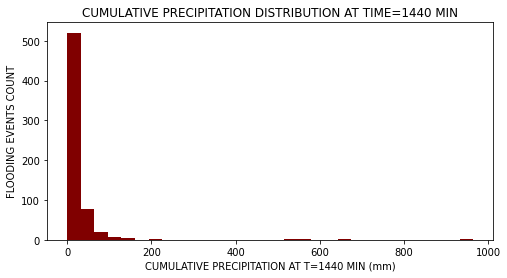

In [122]:
#CUM FLOODING DISTRIBUTION AT TIME=1440
#Note: this visualization is intended to identify the number of flooding records that have a cum precipitation for 1440 min 
#equal to zero, in other words, identify those flooding events when it didn't rain
study_events_flooding['T1440_max'].plot.hist(bins=30, figsize=(8, 4), color='maroon')
plt.title("CUMULATIVE PRECIPITATION DISTRIBUTION AT TIME=1440 MIN")
plt.xlabel("CUMULATIVE PRECIPITATION AT T=1440 MIN (mm)")
plt.ylabel("FLOODING EVENTS COUNT")


In [123]:
study_events_flooding[study_events_flooding['T1440_max']==0]['emergency'].count()

113

**Note: in 113 flooding events the cum precipitation for the previous 24 hrs was zero, meaning that the flooding event was not caused by rains**


In [124]:
#EXCLUDING FLOODING EVENTS NOT CAUSED BY RAINS
study_events_flooding = study_events_flooding[study_events_flooding['T1440_max']>0]
len(study_events_flooding['emergency'])

522

**Note: only the 522 flooding events where the flooding cause was related to rain are included in this project**

In [125]:
#CREATING A NEW CATEGORY COLUMN TO CREATE PIE CHART
count_flooding = study_events_flooding.groupby('municipio')['emergency'].count().sort_values(ascending=False).reset_index(inplace=False)
count_flooding['cat_municipio']=''
for municipio in range(len(count_flooding)):
    count = count_flooding.iloc[municipio,1]
    count_flooding.iloc[municipio,2]='others'
    if count > 7:
        count_flooding.iloc[municipio,2]=count_flooding.iloc[municipio,0]  


([<matplotlib.patches.Wedge at 0x7f1c9e141df0>,
 [Text(0.06920097243149208, 2.298958726339935, 'others'),
  Text(-2.1427171519220605, -0.49876167340626065, 'BOGOTÁ. D.C.'),
  Text(-1.6419874094632498, -1.4641985340670733, 'PEREIRA'),
  Text(-1.0070284806138352, -1.955989171553, 'VILLAVICENCIO'),
  Text(-0.4340675555715868, -2.1567534298570408, 'SANTA MARTA'),
  Text(0.02648001640983023, -2.1998406325756727, 'CALI'),
  Text(0.408076045275895, -2.1618219032269947, 'MONTERÍA'),
  Text(0.764872366641943, -2.062757926356739, 'BARBACOAS'),
  Text(1.076987608874359, -1.918358071458791, 'SAN JOSÉ DE CÚCUTA'),
  Text(1.3418995610231579, -1.743360424044855, 'VALLEDUPAR'),
  Text(1.5603089290804024, -1.550946822373987, 'JAMUNDÍ'),
  Text(1.7352526001408954, -1.3523677065444377, 'PASTO'),
  Text(1.8782254256391344, -1.145543211966573, 'QUIBDÓ'),
  Text(1.9910701949826655, -0.935756099981021, 'RIOHACHA'),
  Text(2.0762307043234967, -0.7275067439030087, 'IBAGUÉ'),
  Text(2.136558513809935, -0.524516

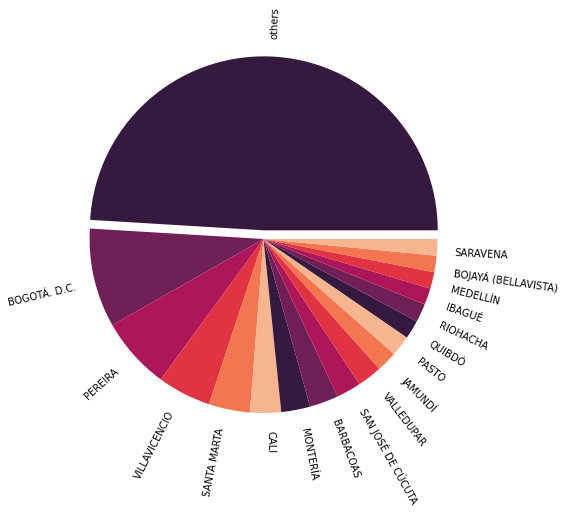

In [126]:
#PLOTTING PIE CHART OF FLOODING EVENTS RECORD COUNT BY MUNICIPIO
pie = count_flooding.groupby('cat_municipio')['emergency'].sum().sort_values(ascending=False)
labels = pie.index
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
palette_color = sns.color_palette('rocket')  
 
plt.pie(pie, labels=labels, rotatelabels=True, radius=2, explode=explode, colors=palette_color) 


In [127]:
#LIST OF TOP 17 MUNICIPIOS WITH THE HIGHER COUNT OF FLOODINGS
municipios_list = count_flooding['municipio'].head(17)
municipios_list

0            BOGOTÁ. D.C.
1                 PEREIRA
2           VILLAVICENCIO
3             SANTA MARTA
4                    CALI
5                MONTERÍA
6               BARBACOAS
7              VALLEDUPAR
8      SAN JOSÉ DE CÚCUTA
9                   PASTO
10                JAMUNDÍ
11                 QUIBDÓ
12               RIOHACHA
13    BOJAYÁ (BELLAVISTA)
14               MEDELLÍN
15               SARAVENA
16                 IBAGUÉ
Name: municipio, dtype: object

In [128]:
#CALCULATING FLOODING EVENTS PERCENTAGE OF TOP 17 MUNICIPIOS IN TOTAL FLOODING EVENTS INCLUDED IN DATASET
count_flooding['emergency'].head(17).sum() / count_flooding['emergency'].sum()

0.5095785440613027

In [129]:
#FLOODING AND NON-FLOODING RECORDS FOR TOP 17 MUNICIPIOS
flooding_top17 = study_events[study_events['municipio'].isin(municipios_list)]
flooding_top17 = flooding_top17[flooding_top17['T1440_max']>0]
flooding_top17['emergency'].value_counts()

False    33221
True       266
Name: emergency, dtype: int64

In [130]:
#TOTAL FLOODING AND NON-FLOODING RECORDS
study_events_records = study_events[study_events['T1440_max']>0]
study_events_records['emergency'].value_counts()

False    189851
True        522
Name: emergency, dtype: int64

**Note: The top 17 municipios account for the 50.96% of total flooding events with a total of 266 records, at the same time, the top 17 municipios account for the 17.49% of the total non-flooding-days records**

In [131]:
#SETTING UP DF TO CREATE PIVOT TABLE

flood_cnt = study_events_flooding[['municipio','anio_observacion_event','mes_observacion_event']].value_counts().reset_index() #creates df table of flooding events in long format
flood_cnt.rename(columns={0:'FLOODING_COUNT'}, inplace=True) #changes header
flood_cnt.loc[:, 'municipio'] = flood_cnt.loc[:, 'municipio'].str.strip().str.upper() #forces uppercases in all DEPARTAMENTOS
flood_cnt.sort_values(by='FLOODING_COUNT')
#flood_cnt.append('BOGOTÁ. D.C.', 2020, 2, 0)
flood_cnt

,municipio,anio_observacion_event,mes_observacion_event,FLOODING_COUNT
0,BOGOTÁ. D.C.,2021.0,6.0,6
1,CALI,2017.0,5.0,6
2,PEREIRA,2017.0,11.0,6
3,SANTA MARTA,2018.0,10.0,6
4,PEREIRA,2017.0,5.0,6
...,...,...,...,...
351,IBAGUÉ,2017.0,10.0,1
352,IBAGUÉ,2017.0,9.0,1
353,GUASCA,2018.0,5.0,1
354,GUADUAS,2021.0,4.0,1


In [132]:
#FLOODING COUNT DATASET FOR TOP 17 MUNICIPIOS
flood_cnt_mun = flood_cnt[flood_cnt['municipio'].isin(municipios_list)]
flood_cnt_mun['mes_observacion_event']=flood_cnt_mun['mes_observacion_event'].astype('int')
#flood_cnt_mun

<ipython-input-132-1f2126728b03>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flood_cnt_mun['mes_observacion_event']=flood_cnt_mun['mes_observacion_event'].astype('int')


Text(0, 0.5, 'FLOODING COUNT')

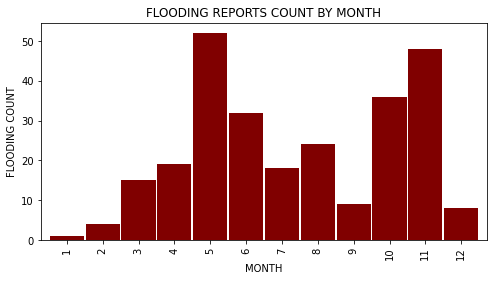

In [133]:
#PLOTTING COUNT OF FLOODING REPORTS BY MONTH FOR TOP 17 MUNICIPIOS
flood_cnt_mun.groupby(['mes_observacion_event'])['FLOODING_COUNT'].sum().plot.bar(width=0.95, color='maroon', figsize=(8, 4))
plt.title("FLOODING REPORTS COUNT BY MONTH")
plt.xlabel('MONTH')
plt.ylabel('FLOODING COUNT')

In [134]:
#CHI SQR ANALYSIS FOR TOP 17 MUNICIPIOS
csq_mes_top17 = chi2_contingency(pd.crosstab(flooding_top17['sgte_mes_observacion'],flooding_top17['emergency']))
csq_mun_top17 = chi2_contingency(pd.crosstab(flooding_top17['municipio'],flooding_top17['emergency']))
csq_zonaH_top17 = chi2_contingency(pd.crosstab(flooding_top17['zona_hidrografica_prec'],flooding_top17['emergency']))
print(f'P-value for Month: {csq_mes_top17[1]} \nP-value for Municipio: {csq_mun_top17[1]} \nP-value for Zona Hidrografica: {csq_zonaH_top17[1]}' )

#la hipotesis nula se descarta, confirmando una asociacion entre las variables

P-value for Month: 8.893943771265363e-15 
P-value for Municipio: 1.6043017538064748e-06 
P-value for Zona Hidrografica: 0.0002696262105049583


**Note: the chi-square test allows discarting the null hypothesis and suggest a strong relation between month and flooding count,
    municipio and flooding count, and zona hidrografica and flooding count**

Text(0, 0.5, 'FLOODING COUNT')

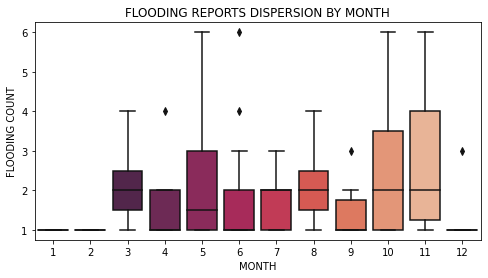

In [135]:
#PLOTTING COUNT OF FLOODING REPORTS DISPERSION BY MONTH FOR TOP 17 MUNICIPIOS DATASET
fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(x="mes_observacion_event", 
            y="FLOODING_COUNT", 
            data=flood_cnt_mun, 
            ax=ax, 
            palette="rocket")
plt.title("FLOODING REPORTS DISPERSION BY MONTH")
plt.xlabel('MONTH')
plt.ylabel('FLOODING COUNT')

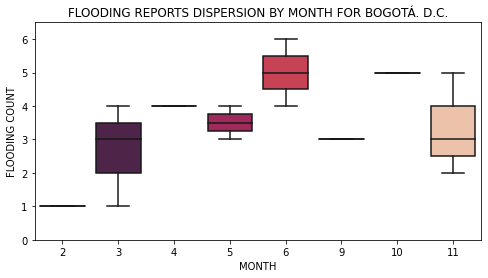

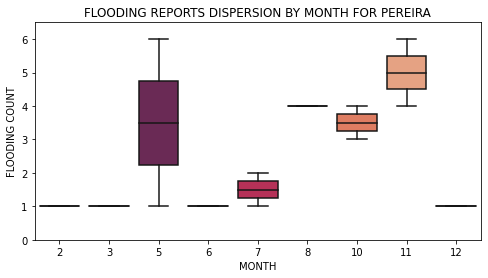

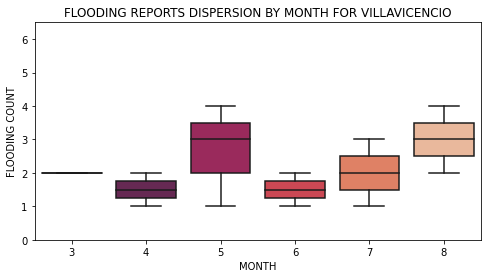

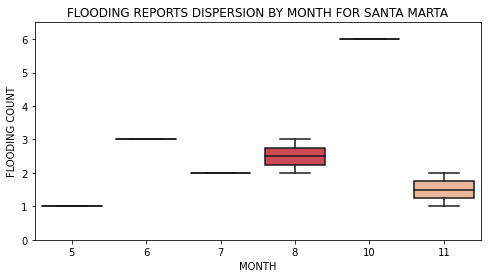

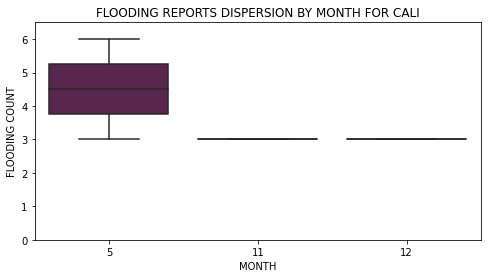

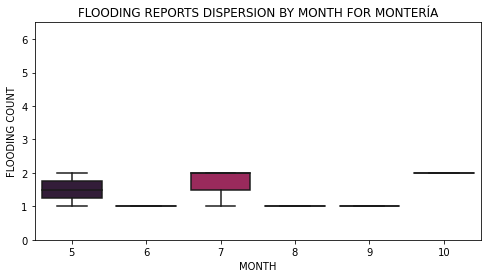

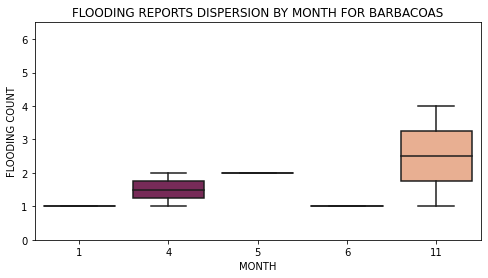

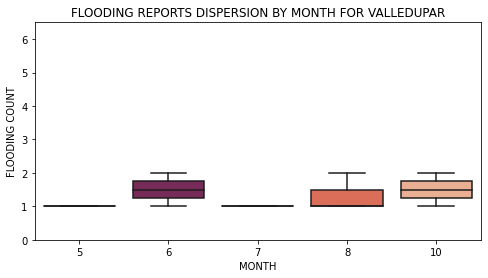

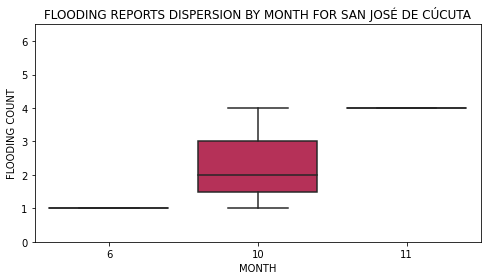

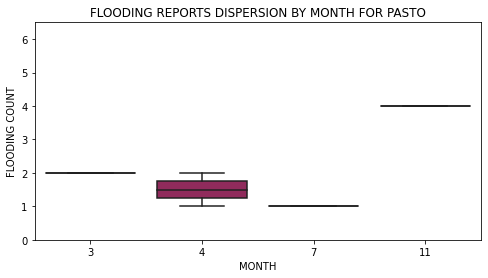

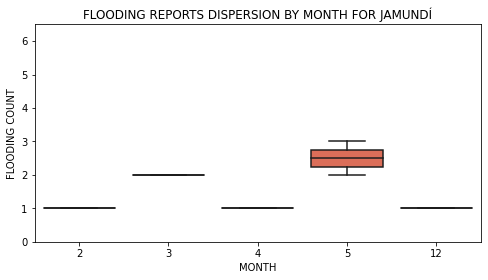

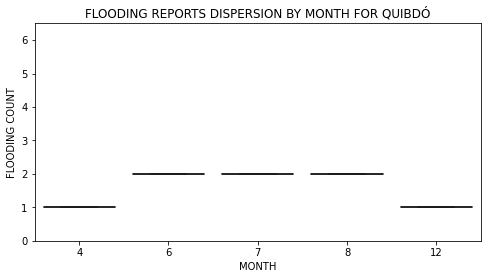

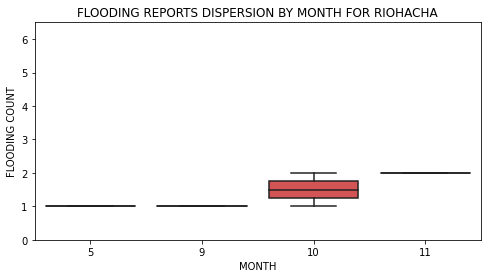

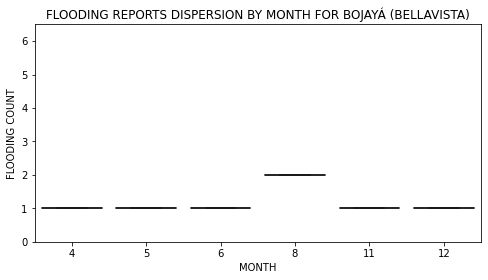

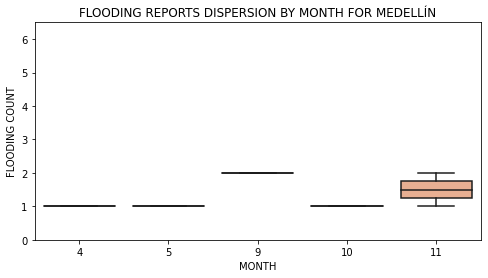

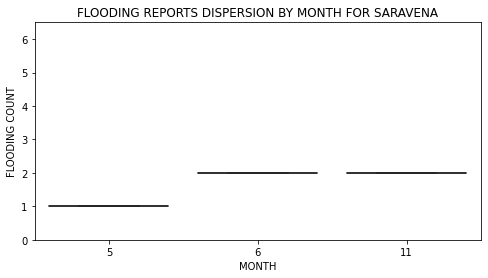

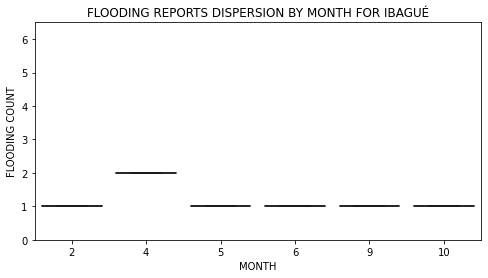

In [136]:
#PLOTTING COUNT OF FLOODING REPORTS DISPERSION BY MONTH BY MUNICIPIO
for municipio in municipios_list:
    dispersion = flood_cnt_mun[flood_cnt_mun['municipio']==municipio]
    
    fig, ax = plt.subplots(figsize=(8,4))
    sns.boxplot(x="mes_observacion_event", 
            y="FLOODING_COUNT", 
            data=dispersion, 
            ax=ax, 
            palette="rocket")
    plt.title(f"FLOODING REPORTS DISPERSION BY MONTH FOR {municipio}")
    plt.xlabel('MONTH')
    plt.ylabel('FLOODING COUNT')
    ax.set_ylim(0,6.5)
    plt.show

**Note: The months with the lower count of flooding reports are also the ones with the lower dispersion of data. Likewise, the months with the higher count of flooding reports are also the ones with the higher dispersion of data. The top 5 municipios with the highest count of flooding reports, are the municipios accounted in a high degree for the dispersion of the Top 17 municipios dataset.**

In [137]:
#ADDING DUMMY RECORDS TO MISSING MONTHS IN DATASET
records=[{'municipio':'BOGOTÁ. D.C.', 'anio_observacion_event':2017, 'mes_observacion_event':1, 'FLOODING_COUNT':0 },
         {'municipio':'BOGOTÁ. D.C.', 'anio_observacion_event':2017, 'mes_observacion_event':2, 'FLOODING_COUNT':0 },
         {'municipio':'BOGOTÁ. D.C.', 'anio_observacion_event':2018, 'mes_observacion_event':1, 'FLOODING_COUNT':0 },
         {'municipio':'BOGOTÁ. D.C.', 'anio_observacion_event':2018, 'mes_observacion_event':9, 'FLOODING_COUNT':0 }, 
         {'municipio':'BOGOTÁ. D.C.', 'anio_observacion_event':2018, 'mes_observacion_event':7, 'FLOODING_COUNT':0 },
         {'municipio':'BOGOTÁ. D.C.', 'anio_observacion_event':2019, 'mes_observacion_event':1, 'FLOODING_COUNT':0 },
         {'municipio':'BOGOTÁ. D.C.', 'anio_observacion_event':2019, 'mes_observacion_event':2, 'FLOODING_COUNT':0 },
         {'municipio':'BOGOTÁ. D.C.', 'anio_observacion_event':2019, 'mes_observacion_event':9, 'FLOODING_COUNT':0 },
         {'municipio':'BOGOTÁ. D.C.', 'anio_observacion_event':2020, 'mes_observacion_event':2, 'FLOODING_COUNT':0 }, 
         {'municipio':'BOGOTÁ. D.C.', 'anio_observacion_event':2020, 'mes_observacion_event':3, 'FLOODING_COUNT':0 }, 
         {'municipio':'BOGOTÁ. D.C.', 'anio_observacion_event':2021, 'mes_observacion_event':1, 'FLOODING_COUNT':0 }, 
         {'municipio':'BOGOTÁ. D.C.', 'anio_observacion_event':2021, 'mes_observacion_event':3, 'FLOODING_COUNT':0 }, 
         {'municipio':'BOGOTÁ. D.C.', 'anio_observacion_event':2021, 'mes_observacion_event':12, 'FLOODING_COUNT':0 },  ]
heatmap_df = flood_cnt_mun.append(records, ignore_index=True)
heatmap_df['anio_observacion_event'] = heatmap_df['anio_observacion_event'].astype(int)
#heatmap_df.sort_values(by=['anio_observacion_event','mes_observacion_event', 'municipio']).head(50)

In [138]:
#CREATING FLOODING COUNT PIVOT TABLE
flood_pvt = heatmap_df.pivot(index=['anio_observacion_event','mes_observacion_event'], columns='municipio', values='FLOODING_COUNT')
flood_pvt.fillna(0, inplace=True)

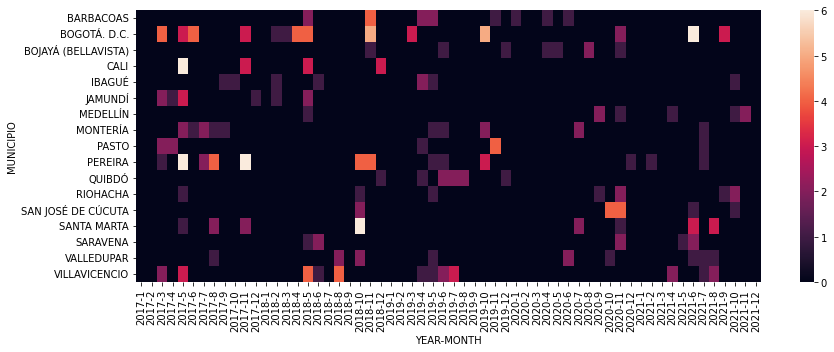

In [139]:
#CREATING HEATMAP OF FLOODING COUNT PER YEAR/MONTH
fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(flood_pvt.T, ax=ax)
plt.xlabel('YEAR-MONTH')
plt.ylabel('MUNICIPIO')
plt.show()

**Note: It can be noted that the data has a significant reduction in reported flooding events for the 2020 period, displaying a low count of flooding reports. This might suggest that the UNGRD Emergencies dataset includes a bias originated in lack of reported events for municipios across the country due to the challenges that COVID-19 pandemic represented back in the time.**

In [140]:
#IMPORTING DAILY CUMULATIVE PRECIPITATION CSV FILE AND FILTERING BY YEAR >= 2017
#NOTE: THE DAILY CUMULATIVE PRECIPITATION DATA WAS CALCULATED FROM THE IDEAM PRECIPITATION DATASET AND STORED IN A DIFFERENT 
#FILE GIVEN THE CONSTRAINS CREATED BY OTHER CALCULATED COLUMNS

precipitation_sum_daily = pd.read_csv("../Datasets/precipitation_interval_sum_daily_220706.csv", dtype={'DIVIPOLA':'str'})
precipitation_sum_daily=precipitation_sum_daily[precipitation_sum_daily['anio_observacion']>=2017]
precipitation_sum_daily = precipitation_sum_daily[precipitation_sum_daily['municipio'].isin(municipios_list)]
len(precipitation_sum_daily)

66262

Text(0, 0.5, 'CUMULATIVE PRECIPITATION (mm)')

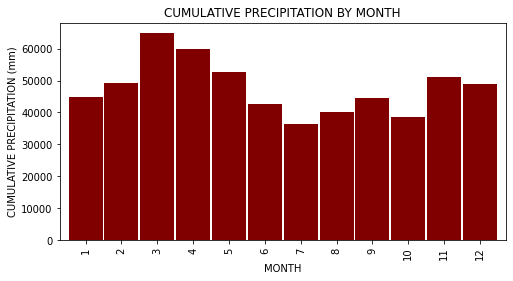

In [141]:
#PLOTTING AGGREGATED DAILY CUMULATIVE PRECIPITATION BY MONTH FOR TOP 17 MUNICIPIOS
#test = precipitation_sum_daily[precipitation_sum_daily['anio_observacion']!=2019]
Cprec = precipitation_sum_daily[['anio_observacion', 'mes_observacion','valor_observado_sum']]
#test = test[test['anio_observacion']==2017]
Cprec.groupby(['mes_observacion'])['valor_observado_sum'].sum().plot.bar(width=0.95, color='maroon', figsize=(8, 4))
plt.title("CUMULATIVE PRECIPITATION BY MONTH")
plt.xlabel('MONTH')
plt.ylabel('CUMULATIVE PRECIPITATION (mm)')



In [142]:
#EVALUATING THE CORRELATION BETWEEN FLOODING OCCURRANCE AND CUMULATIVE VARIABLES
csq_cumPrec_Flood = chi2_contingency(pd.crosstab(flooding_top17['emergency'], flooding_top17['T10_max']))
print(f'P-value for T10: {csq_cumPrec_Flood[1]}' )
csq_cumPrec_Flood = chi2_contingency(pd.crosstab(flooding_top17['emergency'], flooding_top17['T30_max']))
print(f'P-value for T30: {csq_cumPrec_Flood[1]}' )
csq_cumPrec_Flood = chi2_contingency(pd.crosstab(flooding_top17['emergency'], flooding_top17['T60_max']))
print(f'P-value for T60: {csq_cumPrec_Flood[1]}' )
csq_cumPrec_Flood = chi2_contingency(pd.crosstab(flooding_top17['emergency'], flooding_top17['T120_max']))
print(f'P-value for T120: {csq_cumPrec_Flood[1]}' )
csq_cumPrec_Flood = chi2_contingency(pd.crosstab(flooding_top17['emergency'], flooding_top17['T360_max']))
print(f'P-value for T360: {csq_cumPrec_Flood[1]}' )
csq_cumPrec_Flood = chi2_contingency(pd.crosstab(flooding_top17['emergency'], flooding_top17['T720_max']))
print(f'P-value for T720: {csq_cumPrec_Flood[1]}' )
csq_cumPrec_Flood = chi2_contingency(pd.crosstab(flooding_top17['emergency'], flooding_top17['T1440_max']))
print(f'P-value for T1440: {csq_cumPrec_Flood[1]}' )



P-value for T10: 7.149333285490024e-61
P-value for T30: 3.593722378855578e-117
P-value for T60: 4.10706635508263e-133
P-value for T120: 1.1262621312642694e-154
P-value for T360: 9.280226717016475e-223
P-value for T720: 1.7547321223162952e-215
P-value for T1440: 8.390187108278939e-144


Text(0, 0.5, 'CUMULATIVE PRECIPITATION (mm)')

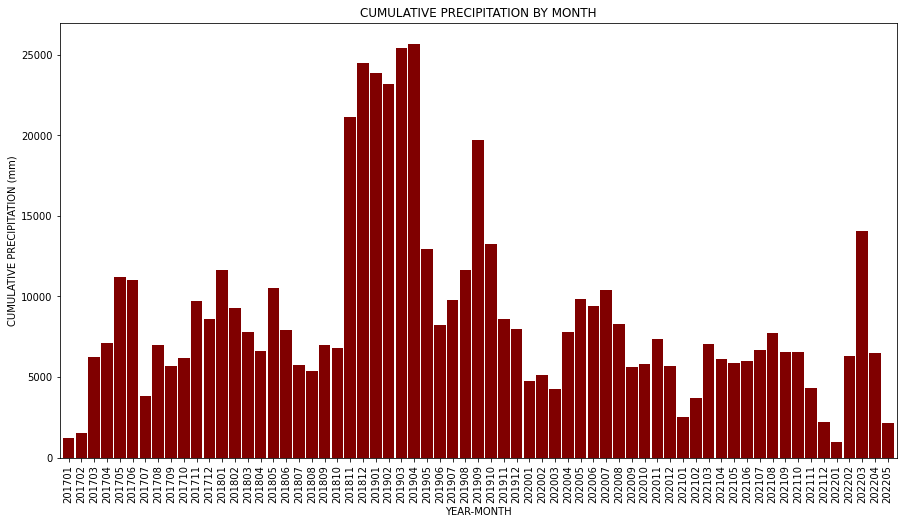

In [143]:
#PLOTTING AGGREGATED DAILY CUMULATIVE PRECIPITATION BY MONTH FOR TOP 17 MUNICIPIOS

precipitation_sum_daily['year_month'] = precipitation_sum_daily['anio_observacion']*100+precipitation_sum_daily['mes_observacion']

test = precipitation_sum_daily[['anio_observacion', 'mes_observacion','year_month','valor_observado_sum']]
#test = test[test['anio_observacion']==2017]
test.groupby(['year_month'])['valor_observado_sum'].sum().plot.bar(width=0.9, color='maroon', figsize=(15, 8))
plt.title("CUMULATIVE PRECIPITATION BY MONTH")
plt.xlabel('YEAR-MONTH')
plt.ylabel('CUMULATIVE PRECIPITATION (mm)')


In [144]:
#SETTING UP DATAFRAME TO PLOT CUM PRECIPITATION VARIABLES (T10_MAX, T30_MAX, ...) IN A TIME SERIES GRAPH

linepl_df = pd.melt(flooding_top17, id_vars=['municipio','mes_observacion_sensor'], value_vars=['T10_max','T30_max','T60_max', 'T120_max', 'T360_max', 'T720_max', 'T1080_max', 'T1440_max'])
linepl_df = linepl_df.groupby(['mes_observacion_sensor','variable']).sum().reset_index()
linepl_df['Time']=0

list_mon=[5,6,10,11]
low_mon=[1,2,12]
#list_mon=[3]
linepl_df['season']='Middle Flooding Month'

for record in range(len(linepl_df)):
    time_max = linepl_df.iloc[record,1]
    if time_max == 'T10_max':
        linepl_df.iloc[record,3]=10
    if time_max == 'T30_max':
        linepl_df.iloc[record,3]=30
    if time_max == 'T60_max':
        linepl_df.iloc[record,3]=60
    if time_max == 'T120_max':
        linepl_df.iloc[record,3]=120
    if time_max == 'T360_max':
        linepl_df.iloc[record,3]=360
    if time_max == 'T720_max':
        linepl_df.iloc[record,3]=720
    if time_max == 'T1080_max':
        linepl_df.iloc[record,3]=1080
    if time_max == 'T1440_max':
        linepl_df.iloc[record,3]=1440
    if linepl_df.iloc[record,0] in (list_mon):
        linepl_df.iloc[record,4]='High Flooding Month'
    if linepl_df.iloc[record,0] in (low_mon):
        linepl_df.iloc[record,4]='Low Flooding Month'

#linepl_df['season'].value_counts()

<ipython-input-145-e2553d1b8dc8>:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0,100000)


[Text(0.5, 0, 'TIME (MIN)'), Text(0, 0.5, 'CUMULATIVE PRECIPITATION (mm)')]

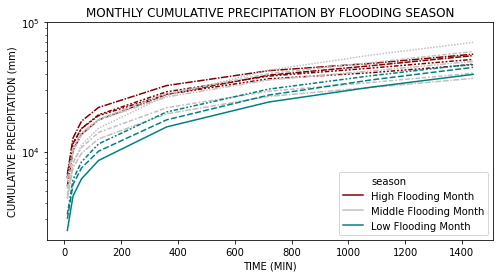

In [145]:
#TIME SERIES PLOT OF CUM PRECIPITATIONS AGGREGATED BY MONTH
f, ax = plt.subplots(1, 1, figsize=(8,4))
g = sns.lineplot(x = 'Time', y = 'value',data = linepl_df, 
             hue = 'season', 
             style = 'mes_observacion_sensor',
             hue_order=['High Flooding Month','Middle Flooding Month', 'Low Flooding Month'], legend = 'brief', palette=['maroon', 'silver', 'teal'])
g.set(title='MONTHLY CUMULATIVE PRECIPITATION BY FLOODING SEASON')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:4], labels=labels[:4])
plt.yscale("log")
ax.set_ylim(0,100000)

ax.set(xlabel='TIME (MIN)', ylabel='CUMULATIVE PRECIPITATION (mm)')

Text(0, 0.5, 'AVERAGE TEMPERATURE (°C)')

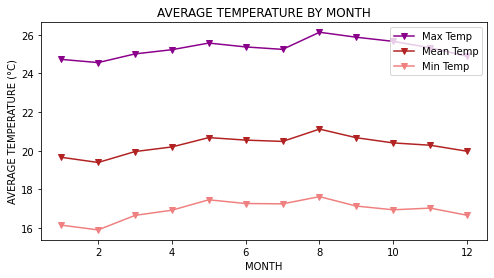

In [146]:
#PLOTTING AGGREGATED DAILY CUMULATIVE PRECIPITATION BY MONTH FOR TOP 17 MUNICIPIOS

Temp_max = flooding_top17[['anio_observacion_sensor', 'mes_observacion_sensor','valor_observado_max_temp']]
Temp_max.groupby(['mes_observacion_sensor'])['valor_observado_max_temp'].mean().plot.line(color='darkmagenta', 
                                                                                          figsize=(8, 4), 
                                                                                          legend='max', 
                                                                                          marker='v')

Temp_mean = flooding_top17[['anio_observacion_sensor', 'mes_observacion_sensor','valor_observado_avg_temp']]
Temp_mean.groupby(['mes_observacion_sensor'])['valor_observado_avg_temp'].mean().plot.line(color='firebrick', 
                                                                                           figsize=(8, 4), 
                                                                                           legend='mean', 
                                                                                           marker='v')

Temp_min = flooding_top17[['anio_observacion_sensor', 'mes_observacion_sensor','valor_observado_min_temp']]
Temp_min.groupby(['mes_observacion_sensor'])['valor_observado_min_temp'].mean().plot.line(color='lightcoral', 
                                                                                          figsize=(8, 4), 
                                                                                          legend='min', 
                                                                                          marker='v')

plt.legend(['Max Temp','Mean Temp','Min Temp'], loc='upper right')
plt.title("AVERAGE TEMPERATURE BY MONTH")
plt.xlabel('MONTH')
plt.ylabel('AVERAGE TEMPERATURE (°C)')

[Text(0.5, 0, 'MONTH'), Text(0, 0.5, 'AVG TEMPERATURE (°C)')]

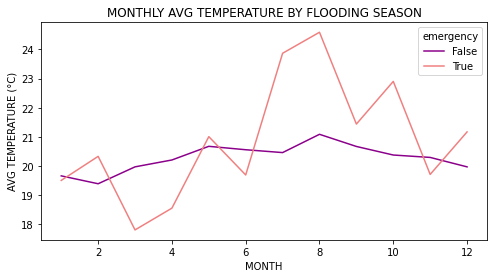

In [250]:
Temp_avg = flooding_top17[['mes_observacion_sensor','valor_observado_avg_temp','emergency']]
Temp_plt =Temp_avg.groupby(['mes_observacion_sensor','emergency'])['valor_observado_avg_temp'].mean().reset_index()

f, ax = plt.subplots(1, 1, figsize=(8,4))
a = sns.lineplot(x = 'mes_observacion_sensor', y = 'valor_observado_avg_temp',data = Temp_plt, 
             hue = 'emergency', 
             palette=['darkmagenta', 'lightcoral'])

a.set(title='MONTHLY AVG TEMPERATURE BY FLOODING SEASON')
ax.set(xlabel='MONTH', ylabel='AVG TEMPERATURE (°C)')

[Text(0.5, 0, 'MONTH'), Text(0, 0.5, 'AVG PRESSURE (mmHg)')]

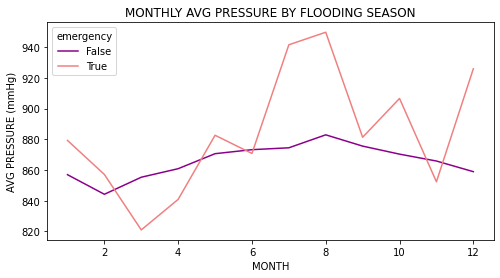

In [251]:
Press_avg = flooding_top17[['mes_observacion_sensor','valor_observado_avg','emergency']]
Press_plt =Press_avg.groupby(['mes_observacion_sensor','emergency'])['valor_observado_avg'].mean().reset_index()

f, ax = plt.subplots(1, 1, figsize=(8,4))
a = sns.lineplot(x = 'mes_observacion_sensor', y = 'valor_observado_avg',data = Press_plt, 
             hue = 'emergency', 
             palette=['darkmagenta', 'lightcoral'])

a.set(title='MONTHLY AVG PRESSURE BY FLOODING SEASON')
ax.set(xlabel='MONTH', ylabel='AVG PRESSURE (mmHg)')
